**Imports**

In [1]:
import gc
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn import preprocessing
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import log_loss, r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from skopt import gp_minimize
from skopt.plots import plot_convergence
import json

%matplotlib inline

**Setup Environment**

In [2]:
from kaggle.competitions import twosigmanews
env = twosigmanews.make_env()

Loading the data... This could take a minute.
Done!


**Get Training Data**

In [3]:
(market_train, news_train) = env.get_training_data()

In [4]:
market_train.describe()

volume      ...           universe
count  4.072956e+06      ...       4.072956e+06
mean   2.665312e+06      ...       5.949365e-01
std    7.687606e+06      ...       4.909044e-01
min    0.000000e+00      ...       0.000000e+00
25%    4.657968e+05      ...       0.000000e+00
50%    9.821000e+05      ...       1.000000e+00
75%    2.403165e+06      ...       1.000000e+00
max    1.226791e+09      ...       1.000000e+00

[8 rows x 13 columns]

In [5]:
market_train.shape

(4072956, 16)

**Exploratory Data Analysis**

**Market Data**
* time(datetime64[ns, UTC]) - the current time (in marketdata, all rows are taken at 22:00 UTC)
* assetCode(object) - a unique id of an asset
* assetName(category) - the name that corresponds to a group of assetCodes. These may be "Unknown" if the corresponding assetCode does not have any rows in the news data.
* universe(float64) - a boolean indicating whether or not the instrument on that day will be included in scoring. This value is not provided outside of the training data time period. The trading universe on a given date is the set of instruments that are avilable for trading (the scoring function will not consider instruments that are not in the trading universe). The trading universe changes daily.
* volume(float64) - trading volume in shares for the day
* close(float64) - the close price for the day (not adjusted for splits or dividends)
* open(float64) - the open price for the day (not adjusted for splits or dividends)
* returnsClosePrevRaw1(float64) - see returns explanation above
* returnsOpenPrevRaw1(float64) - see returns explanation above
* returnsClosePrevMktres1(float64) - see returns explanation above
* returnsOpenPrevMktres1(float64) - see returns explanation above
* returnsClosePrevRaw10(float64) - see returns explanation above
* returnsOpenPrevRaw10(float64) - see returns explanation above
* returnsClosePrevMktres10(float64) - see returns explanation above
* returnsOpenPrevMktres10(float64) - see returns explanation above
* returnsOpenNextMktres10(float64) - 10 day, market-residualized return. This is the target variable used in competition scoring. The market data has been filtered such that returnsOpenNextMktres10 is always not null.

**News Data**

* time(datetime64[ns, UTC]) - UTC timestamp showing when the data was available on the feed (second precision)
* sourceTimestamp(datetime64[ns, UTC]) - UTC timestamp of this news item when it was created
* firstCreated(datetime64[ns, UTC]) - UTC timestamp for the first version of the item
* sourceId(object) - an Id for each news item
* headline(object) - the item's headline
* urgency(int8) - differentiates story types (1: alert, 3: article)
* takeSequence(int16) - the take sequence number of the news item, starting at 1. For a given story, alerts and articles have separate sequences.
* provider(category) - identifier for the organization which provided the news item (e.g. RTRS for Reuters News, BSW for Business Wire)
* subjects(category) - topic codes and company identifiers that relate to this news item. Topic codes describe the news item's subject matter. These can cover asset classes, geographies, events, industries/sectors, and other types.
* audiences(category) - identifies which desktop news product(s) the news item belongs to. They are typically tailored to specific audiences. (e.g. "M" for Money International News Service and "FB" for French General News Service)
* bodySize(int32) - the size of the current version of the story body in characters
* companyCount(int8) - the number of companies explicitly listed in the news item in the subjects field
* headlineTag(object) - the Thomson Reuters headline tag for the news item
* marketCommentary(bool) - boolean indicator that the item is discussing general market conditions, such as "After the Bell" summaries
* sentenceCount(int16) - the total number of sentences in the news item. Can be used in conjunction with firstMentionSentence to determine the relative position of the first mention in the item.
* wordCount(int32) - the total number of lexical tokens (words and punctuation) in the news item
* assetCodes(category) - list of assets mentioned in the item
* assetName(category) - name of the asset
* firstMentionSentence(int16) - the first sentence, starting with the headline, in which the scored asset is mentioned.
1: headline
2: first sentence of the story body
3: second sentence of the body, etc
0: the asset being scored was not found in the news item's headline or body text. As a result, the entire news item's text (headline + body) will be used to determine the sentiment score.
* relevance(float32) - a decimal number indicating the relevance of the news item to the asset. It ranges from 0 to 1. If the asset is mentioned in the headline, the relevance is set to 1. When the item is an alert (urgency == 1), relevance should be gauged by firstMentionSentence instead.
* sentimentClass(int8) - indicates the predominant sentiment class for this news item with respect to the asset. The indicated class is the one with the highest probability.
* sentimentNegative(float32) - probability that the sentiment of the news item was negative for the asset
* sentimentNeutral(float32) - probability that the sentiment of the news item was neutral for the asset
* sentimentPositive(float32) - probability that the sentiment of the news item was positive for the asset
* sentimentWordCount(int32) - the number of lexical tokens in the sections of the item text that are deemed relevant to the asset. This can be used in conjunction with wordCount to determine the proportion of the news item discussing the asset.
* noveltyCount12H(int16) - The 12 hour novelty of the content within a news item on a particular asset. It is calculated by comparing it with the asset-specific text over a cache of previous news items that contain the asset.
* noveltyCount24H(int16) - same as above, but for 24 hours
* noveltyCount3D(int16) - same as above, but for 3 days
* noveltyCount5D(int16) - same as above, but for 5 days
* noveltyCount7D(int16) - same as above, but for 7 days
* volumeCounts12H(int16) - the 12 hour volume of news for each asset. A cache of previous news items is maintained and the number of news items that mention the asset within each of five historical periods is calculated.
* volumeCounts24H(int16) - same as above, but for 24 hours
* volumeCounts3D(int16) - same as above, but for 3 days
* volumeCounts5D(int16) - same as above, but for 5 days
* volumeCounts7D(int16) - same as above, but for 7 days

In [6]:
data = []
for asset in np.random.choice(market_train['assetName'].unique(), 10):
    asset_df = market_train[(market_train['assetName'] == asset)]

    data.append(go.Scatter(
        x = asset_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
        y = asset_df['close'].values,
        name = asset
    ))
layout = go.Layout(dict(title = "Closing prices of 10 random assets",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Price (USD)'),
                  ),legend=dict(
                orientation="h"))
py.iplot(dict(data=data, layout=layout), filename='basic-line')

In [7]:
data = []
for i in [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]:
    price_df = market_train.groupby('time')['close'].quantile(i).reset_index()

    data.append(go.Scatter(
        x = price_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
        y = price_df['close'].values,
        name = f'{i} quantile'
    ))
layout = go.Layout(dict(title = "Trends of closing prices by quantiles",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Price (USD)'),
                  ),legend=dict(
                orientation="h"))
py.iplot(dict(data=data, layout=layout), filename='basic-line')

In [8]:
data = []
for i in [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]:
    price_df = market_train.groupby('time')['returnsOpenNextMktres10'].quantile(i).reset_index()

    data.append(go.Scatter(
        x = price_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
        y = price_df['returnsOpenNextMktres10'].values,
        name = f'{i} quantile'
    ))
layout = go.Layout(dict(title = "Trends of returnsOpenNextMktres10 by quantiles",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Price (USD)'),
                  ),legend=dict(
                orientation="h"),)
py.iplot(dict(data=data, layout=layout), filename='basic-line')

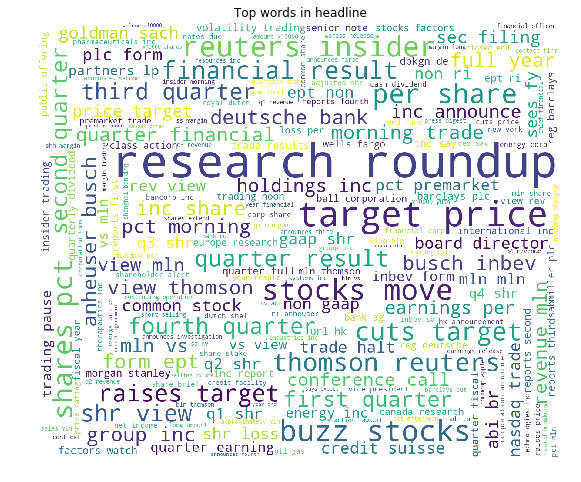

In [9]:
text = ' '.join(news_train['headline'].str.lower().values[-1000000:])
stop = set(stopwords.words('english'))
wordcloud = WordCloud(max_font_size=None, stopwords=stop, background_color='white',
                      width=1200, height=1000).generate(text)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud)
plt.title('Top words in headline')
plt.axis("off")
plt.show()

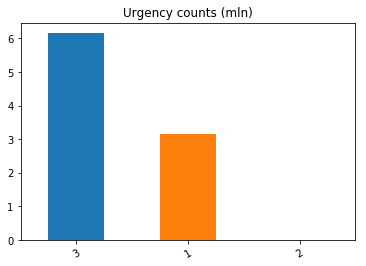

In [10]:
(news_train['urgency'].value_counts() / 1000000).plot('bar');
plt.xticks(rotation=30);
plt.title('Urgency counts (mln)');

In [11]:
news_train['provider'].value_counts().head(10)

RTRS    7287840
PRN      687327
BSW      659798
MKW      171630
GNW      156367
RNS      119591
LSE       64250
HIIS      61921
CNW       46459
ONE       25233
Name: provider, dtype: int64

In [12]:
for i, j in zip([-1, 0, 1], ['negative', 'neutral', 'positive']):
    df_sentiment = news_train.loc[news_train['sentimentClass'] == i, 'assetName']
    print(f'Top mentioned companies for {j} sentiment are:')
    print(df_sentiment.value_counts().head(5))
    print('')

Top mentioned companies for negative sentiment are:
Citigroup Inc              30823
JPMorgan Chase & Co        29129
Bank of America Corp       28197
Apple Inc                  26702
Goldman Sachs Group Inc    25044
Name: assetName, dtype: int64

Top mentioned companies for neutral sentiment are:
Barclays PLC         24898
HSBC Holdings PLC    23191
Deutsche Bank AG     20702
BHP Billiton PLC     18019
Rio Tinto PLC        16782
Name: assetName, dtype: int64

Top mentioned companies for positive sentiment are:
Barclays PLC             22855
Apple Inc                22770
General Electric Co      20055
Royal Dutch Shell PLC    18206
Citigroup Inc            18025
Name: assetName, dtype: int64



**Preprocess Data**

In [13]:
market_train = market_train.loc[market_train['time'] >= '2010-01-01 22:00:00+0000']
news_train = news_train.loc[news_train['time'] >= '2010-01-01 22:00:00+0000']

In [14]:
def preprocess_news(news_train):
    drop_list = [
        'audiences', 'subjects', 'assetName',
        'headline', 'firstCreated', 'sourceTimestamp',
    ]
    news_train.drop(drop_list, axis=1, inplace=True)
    
    # Factorize categorical columns
    for col in ['headlineTag', 'provider', 'sourceId']:
        news_train[col], uniques = pd.factorize(news_train[col])
        del uniques
    
    # Remove {} and '' from assetCodes column
    news_train['assetCodes'] = news_train['assetCodes'].apply(lambda x: x[1:-1].replace("'", ""))
    return news_train

news_train = preprocess_news(news_train)

**Split Asset Codes in News Data**

In [15]:
def unstack_asset_codes(news_train):
    codes = []
    indexes = []
    for i, values in news_train['assetCodes'].iteritems():
        explode = values.split(", ")
        codes.extend(explode)
        repeat_index = [int(i)]*len(explode)
        indexes.extend(repeat_index)
    index_df = pd.DataFrame({'news_index': indexes, 'assetCode': codes})
    del codes, indexes
    gc.collect()
    return index_df

index_df = unstack_asset_codes(news_train)
index_df.head()

news_index assetCode
0     2325409     TWC.N
1     2325410    NWS.OQ
2     2325410     NWS.O
3     2325410    NWSA.O
4     2325410   NWSA.OQ

In [16]:
def merge_news_on_index(news_train, index_df):
    news_train['news_index'] = news_train.index.copy()

    # Merge news on unstacked assets
    news_unstack = index_df.merge(news_train, how='left', on='news_index')
    news_unstack.drop(['news_index', 'assetCodes', 'sourceId'], axis=1, inplace=True)
    return news_unstack

news_unstack = merge_news_on_index(news_train, index_df)
del news_train, index_df
gc.collect()
news_unstack.head(3)

assetCode      ...       volumeCounts7D
0     TWC.N      ...                   35
1    NWS.OQ      ...                   43
2     NWS.O      ...                   43

[3 rows x 28 columns]

**Group Data**

In [17]:
gc.collect()
def group_news(news_frame):
    news_frame['date'] = news_frame.time.dt.date  # Add date column
    
    aggregations = ['mean']
    gp = news_frame.groupby(['assetCode', 'date']).agg(aggregations)
    gp.columns = pd.Index(["{}_{}".format(e[0], e[1]) for e in gp.columns.tolist()])
    gp.reset_index(inplace=True)
    # Set datatype to float32
    float_cols = {c: 'float32' for c in gp.columns if c not in ['assetCode', 'date']}
    return gp.astype(float_cols)

news_agg = group_news(news_unstack)
del news_unstack; gc.collect()
news_agg.head(3)

assetCode         ...         volumeCounts7D_mean
0  000030.KS         ...                         0.0
1  000030.KS         ...                         0.0
2  000030.KS         ...                         1.0

[3 rows x 28 columns]

**Merge News with Market Data**

In [18]:
market_train['date'] = market_train.time.dt.date
df = market_train.merge(news_agg, how='left', on=['assetCode', 'date'])
del market_train, news_agg
gc.collect()
df.head(3)

time         ...         volumeCounts7D_mean
0 2010-01-04 22:00:00+00:00         ...                         0.5
1 2010-01-04 22:00:00+00:00         ...                         NaN
2 2010-01-04 22:00:00+00:00         ...                         NaN

[3 rows x 43 columns]

**Data Cleanup**

In [19]:
def missing_value_impute(data):
    grouped_data = data.groupby('assetCode')
    for i in data.columns:
        if data[i].dtype == "object":
            data[i] = data[i].fillna("other")
        elif (data[i].dtype == "float32" or data[i].dtype == "float64"):
            data[i] = data[i].fillna(grouped_data[i].mean())
            data[i] = data[i].fillna(0)
        else:
            pass
    return data

In [20]:
gc.collect()
missing_value_impute(df)

time         ...         volumeCounts7D_mean
0       2010-01-04 22:00:00+00:00         ...                    0.500000
1       2010-01-04 22:00:00+00:00         ...                    0.000000
2       2010-01-04 22:00:00+00:00         ...                    0.000000
3       2010-01-04 22:00:00+00:00         ...                   52.363636
4       2010-01-04 22:00:00+00:00         ...                    0.000000
5       2010-01-04 22:00:00+00:00         ...                    0.000000
6       2010-01-04 22:00:00+00:00         ...                    0.000000
7       2010-01-04 22:00:00+00:00         ...                    0.000000
8       2010-01-04 22:00:00+00:00         ...                    0.000000
9       2010-01-04 22:00:00+00:00         ...                    0.000000
10      2010-01-04 22:00:00+00:00         ...                    0.500000
11      2010-01-04 22:00:00+00:00         ...                    0.000000
12      2010-01-04 22:00:00+00:00         ...                    0.000000
13      2010-01-04 22:00:00+00:00         ...                    0.000000
14      2010-01-04 22:00:00+00:00         ...                    0.000000
15      2010-01-04 22:00:00+00:00         ...                    0.000000
16      2010-01-04 22:00:00+00:00         ...                    0.000000
17      2010-01-04 22:00:00+00:00         ...                    9.500000
18      2010-01-04 22:00:00+00:00         ...                   33.857143
19      2010-01-04 22:00:00+00:00         ...                    0.000000
20      2010-01-04 22:00:00+00:00         ...                    0.000000
21      2010-01-04 22:00:00+00:00         ...                    0.000000
22      2010-01-04 22:00:00+00:00         ...                    0.000000
23      2010-01-04 22:00:00+00:00         ...                    0.000000
24      2010-01-04 22:00:00+00:00         ...                    0.000000
25      2010-01-04 22:00:00+00:00         ...                    0.000000
26      2010-01-04 22:00:00+00:00         ...                    0.000000
27      2010-01-04 22:00:00+00:00         ...                    0.000000
28      2010-01-04 22:00:00+00:00         ...                    0.000000
29      2010-01-04 22:00:00+00:00         ...                    0.000000
...                           ...         ...                         ...
2946709 2016-12-30 22:00:00+00:00         ...                    0.000000
2946710 2016-12-30 22:00:00+00:00         ...                    0.000000
2946711 2016-12-30 22:00:00+00:00         ...                    0.000000
2946712 2016-12-30 22:00:00+00:00         ...                    0.000000
2946713 2016-12-30 22:00:00+00:00         ...                    0.000000
2946714 2016-12-30 22:00:00+00:00         ...                   10.500000
2946715 2016-12-30 22:00:00+00:00         ...                    0.000000
2946716 2016-12-30 22:00:00+00:00         ...                    0.000000
2946717 2016-12-30 22:00:00+00:00         ...                    0.000000
2946718 2016-12-30 22:00:00+00:00         ...                    0.000000
2946719 2016-12-30 22:00:00+00:00         ...                    0.000000
2946720 2016-12-30 22:00:00+00:00         ...                    0.000000
2946721 2016-12-30 22:00:00+00:00         ...                    0.000000
2946722 2016-12-30 22:00:00+00:00         ...                    0.000000
2946723 2016-12-30 22:00:00+00:00         ...                    0.000000
2946724 2016-12-30 22:00:00+00:00         ...                    0.000000
2946725 2016-12-30 22:00:00+00:00         ...                    0.000000
2946726 2016-12-30 22:00:00+00:00         ...                    0.000000
2946727 2016-12-30 22:00:00+00:00         ...                    3.000000
2946728 2016-12-30 22:00:00+00:00         ...                    1.000000
2946729 2016-12-30 22:00:00+00:00         ...                    0.000000
2946730 2016-12-30 22:00:00+00:00         ...                    0.000000
2946731 2016-12-30 22:00:00+00:00

In [21]:
df.isna().sum()

time                         0
assetCode                    0
assetName                    0
volume                       0
close                        0
open                         0
returnsClosePrevRaw1         0
returnsOpenPrevRaw1          0
returnsClosePrevMktres1      0
returnsOpenPrevMktres1       0
returnsClosePrevRaw10        0
returnsOpenPrevRaw10         0
returnsClosePrevMktres10     0
returnsOpenPrevMktres10      0
returnsOpenNextMktres10      0
universe                     0
date                         0
urgency_mean                 0
takeSequence_mean            0
provider_mean                0
bodySize_mean                0
companyCount_mean            0
headlineTag_mean             0
marketCommentary_mean        0
sentenceCount_mean           0
wordCount_mean               0
firstMentionSentence_mean    0
relevance_mean               0
sentimentClass_mean          0
sentimentNegative_mean       0
sentimentNeutral_mean        0
sentimentPositive_mean       0
sentimen

In [22]:
gc.collect()

299

**Data split**

In [23]:
date = df.date
num_target = df.returnsOpenNextMktres10.astype('float32')
bin_target = (df.returnsOpenNextMktres10 >= 0).astype('int8')
# universe = df.universe.astype('int8')
# Drop columns that are not features
universe_data = df['universe']
time_data = df['time']
df.drop([
    'returnsOpenNextMktres10', 
    'date', 
    'universe', 
    'assetCode', 
    'assetName', 
    'time'], 
        axis=1, inplace=True)
df = df.astype('float32')  # Set all remaining columns to float32 datatype
gc.collect()

0

In [24]:
x_train, x_test, y_train, y_test, u_train, u_test, t_train, t_test = \
    train_test_split(df, bin_target, universe_data, time_data, 
                     test_size=0.10, shuffle=False, random_state=99)

**Baseline Model - ExtraTreesClassifier**

In [25]:
def plot_model_performance(y, y_hat):
    print("R2 score: ", r2_score(y, y_hat))
    print('Mean Absolute Error:', mean_absolute_error(y, y_hat))
    mse = mean_squared_error(y, y_hat)
    print('Mean Squared Error:', mse)  
    print('Root Mean Squared Error:', np.sqrt(mse)) 

In [26]:
def do_baseline_modeling(x_train, x_test, y_train, y_test):
    model = ExtraTreesClassifier(bootstrap=True, oob_score=True,
                                    n_estimators=10, class_weight="balanced_subsample")
    prev_oob_score = 0.0
    for i in range(1, 10):
        gc.collect()
        model.set_params(n_estimators=i)    
        model.fit(x_train, y_train)
        print(model.oob_score_)
        if i > 1 and (model.oob_score_ - prev_oob_score < 0.05):
            gc.collect()
            break
        prev_oob_score = model.oob_score_
        gc.collect()
    y_hat = model.predict(x_test)
    plot_model_performance(y_test, y_hat)
    return model

In [27]:
baseline_model = do_baseline_modeling(x_train, x_test, y_train, y_test)
imp_features = baseline_model.feature_importances_
print(imp_features)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: UserWarning:

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning:

invalid value encountered in true_divide



0.49997643345845594


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: UserWarning:

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning:

invalid value encountered in true_divide



0.5028379771988998
R2 score:  -1.0055625520697893
Mean Absolute Error: 0.5010621907599585
Mean Squared Error: 0.5010621907599585
Root Mean Squared Error: 0.7078574650026364
[0.07295341 0.07387415 0.07281427 0.07421339 0.07378497 0.07457134
 0.07364677 0.07679908 0.07647995 0.07504636 0.07593488 0.00397351
 0.00424827 0.00673043 0.00894319 0.00683087 0.00594931 0.00137517
 0.00911124 0.00960836 0.00662002 0.00671304 0.00524269 0.00995828
 0.00955307 0.00955676 0.00989962 0.00453459 0.0045793  0.00485491
 0.00532807 0.00584389 0.00636361 0.00737918 0.00845485 0.00886103
 0.00936818]


**Hyper parameter Tuning**

In [28]:
def sigma_score(preds, valid_data):
    df_time = valid_data.params['extra_time']
    labels = valid_data.get_label()
    x_t = preds * labels
    x_t_sum = x_t.groupby(df_time).sum()
    score = x_t_sum.mean() / x_t_sum.std()
    return 'sigma_score', score, True

[0.05260027828884955, 3395, 286, 837, 217]


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning:

Found `num_iteration` in params. Will use it instead of argument



[1]	valid_0's binary_logloss: 0.69239
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.6919
[3]	valid_0's binary_logloss: 0.691477
[4]	valid_0's binary_logloss: 0.691135
[5]	valid_0's binary_logloss: 0.690826
[6]	valid_0's binary_logloss: 0.69056
[7]	valid_0's binary_logloss: 0.690334
[8]	valid_0's binary_logloss: 0.690422
[9]	valid_0's binary_logloss: 0.690227
[10]	valid_0's binary_logloss: 0.690058
[11]	valid_0's binary_logloss: 0.689903
[12]	valid_0's binary_logloss: 0.68996
[13]	valid_0's binary_logloss: 0.689837
[14]	valid_0's binary_logloss: 0.689745
[15]	valid_0's binary_logloss: 0.689661
[16]	valid_0's binary_logloss: 0.689589
[17]	valid_0's binary_logloss: 0.68952
[18]	valid_0's binary_logloss: 0.689474
[19]	valid_0's binary_logloss: 0.689453
[20]	valid_0's binary_logloss: 0.689423
[21]	valid_0's binary_logloss: 0.689427
[22]	valid_0's binary_logloss: 0.689427
[23]	valid_0's binary_logloss: 0.689415
[24]	valid_0's binary_logloss: 0.6

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning:

Found `num_iteration` in params. Will use it instead of argument



[1]	valid_0's binary_logloss: 0.690722
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.69004
[3]	valid_0's binary_logloss: 0.689958
[4]	valid_0's binary_logloss: 0.690198
[5]	valid_0's binary_logloss: 0.690549
[6]	valid_0's binary_logloss: 0.691058
[7]	valid_0's binary_logloss: 0.691524
[8]	valid_0's binary_logloss: 0.691019
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.689958
score:  0.24836930826366266
[0.20072152642872956, 3090, 297, 958, 208]


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning:

Found `num_iteration` in params. Will use it instead of argument



[1]	valid_0's binary_logloss: 0.691175
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.690277
[3]	valid_0's binary_logloss: 0.689815
[4]	valid_0's binary_logloss: 0.689685
[5]	valid_0's binary_logloss: 0.689758
[6]	valid_0's binary_logloss: 0.689968
[7]	valid_0's binary_logloss: 0.690152
[8]	valid_0's binary_logloss: 0.689916
[9]	valid_0's binary_logloss: 0.690223
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.689685
score:  0.24828397584687098
[0.1392473334687837, 3019, 296, 833, 216]


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning:

Found `num_iteration` in params. Will use it instead of argument



[1]	valid_0's binary_logloss: 0.691627
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.690725
[3]	valid_0's binary_logloss: 0.690147
[4]	valid_0's binary_logloss: 0.689782
[5]	valid_0's binary_logloss: 0.689576
[6]	valid_0's binary_logloss: 0.68943
[7]	valid_0's binary_logloss: 0.689469
[8]	valid_0's binary_logloss: 0.689463
[9]	valid_0's binary_logloss: 0.689516
[10]	valid_0's binary_logloss: 0.689635
[11]	valid_0's binary_logloss: 0.689763
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.68943
score:  0.2481864349387085
[0.182802296099798, 3098, 263, 844, 208]


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning:

Found `num_iteration` in params. Will use it instead of argument



[1]	valid_0's binary_logloss: 0.691294
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.690392
[3]	valid_0's binary_logloss: 0.689916
[4]	valid_0's binary_logloss: 0.689731
[5]	valid_0's binary_logloss: 0.689717
[6]	valid_0's binary_logloss: 0.689897
[7]	valid_0's binary_logloss: 0.690067
[8]	valid_0's binary_logloss: 0.689876
[9]	valid_0's binary_logloss: 0.690069
[10]	valid_0's binary_logloss: 0.690315
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.689717
score:  0.24828233966928528
[0.21961005577960954, 3310, 261, 929, 205]


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning:

Found `num_iteration` in params. Will use it instead of argument



[1]	valid_0's binary_logloss: 0.691097
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.690251
[3]	valid_0's binary_logloss: 0.689942
[4]	valid_0's binary_logloss: 0.689927
[5]	valid_0's binary_logloss: 0.690104
[6]	valid_0's binary_logloss: 0.690391
[7]	valid_0's binary_logloss: 0.690673
[8]	valid_0's binary_logloss: 0.690366
[9]	valid_0's binary_logloss: 0.690734
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.689927
score:  0.24837547787513914
[0.2313506107789638, 3422, 285, 936, 201]


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning:

Found `num_iteration` in params. Will use it instead of argument



[1]	valid_0's binary_logloss: 0.691019
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.690189
[3]	valid_0's binary_logloss: 0.689956
[4]	valid_0's binary_logloss: 0.690006
[5]	valid_0's binary_logloss: 0.690282
[6]	valid_0's binary_logloss: 0.690547
[7]	valid_0's binary_logloss: 0.690927
[8]	valid_0's binary_logloss: 0.690631
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.689956
score:  0.24842693333491092
[0.294701961056617, 3140, 286, 901, 219]


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning:

Found `num_iteration` in params. Will use it instead of argument



[1]	valid_0's binary_logloss: 0.690677
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.689887
[3]	valid_0's binary_logloss: 0.689927
[4]	valid_0's binary_logloss: 0.690322
[5]	valid_0's binary_logloss: 0.690783
[6]	valid_0's binary_logloss: 0.691357
[7]	valid_0's binary_logloss: 0.691976
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.689887
score:  0.24837521573771032
[0.05871558491722697, 3388, 277, 815, 207]


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning:

Found `num_iteration` in params. Will use it instead of argument



[1]	valid_0's binary_logloss: 0.692318
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.691777
[3]	valid_0's binary_logloss: 0.691345
[4]	valid_0's binary_logloss: 0.690965
[5]	valid_0's binary_logloss: 0.690654
[6]	valid_0's binary_logloss: 0.690384
[7]	valid_0's binary_logloss: 0.690167
[8]	valid_0's binary_logloss: 0.690263
[9]	valid_0's binary_logloss: 0.690058
[10]	valid_0's binary_logloss: 0.6899
[11]	valid_0's binary_logloss: 0.689743
[12]	valid_0's binary_logloss: 0.689793
[13]	valid_0's binary_logloss: 0.689668
[14]	valid_0's binary_logloss: 0.689574
[15]	valid_0's binary_logloss: 0.68949
[16]	valid_0's binary_logloss: 0.689443
[17]	valid_0's binary_logloss: 0.689405
[18]	valid_0's binary_logloss: 0.689397
[19]	valid_0's binary_logloss: 0.689376
[20]	valid_0's binary_logloss: 0.689389
[21]	valid_0's binary_logloss: 0.689381
[22]	valid_0's binary_logloss: 0.689382
[23]	valid_0's binary_logloss: 0.68937
[24]	valid_0's binary_logloss: 0

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning:

Found `num_iteration` in params. Will use it instead of argument



[1]	valid_0's binary_logloss: 0.691712
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.690854
[3]	valid_0's binary_logloss: 0.690291
[4]	valid_0's binary_logloss: 0.689939
[5]	valid_0's binary_logloss: 0.689726
[6]	valid_0's binary_logloss: 0.689629
[7]	valid_0's binary_logloss: 0.689617
[8]	valid_0's binary_logloss: 0.689586
[9]	valid_0's binary_logloss: 0.68959
[10]	valid_0's binary_logloss: 0.689615
[11]	valid_0's binary_logloss: 0.689715
[12]	valid_0's binary_logloss: 0.68962
[13]	valid_0's binary_logloss: 0.68972
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.689586
score:  0.24822858751266344
[0.05871558491722697, 3388, 277, 815, 207]


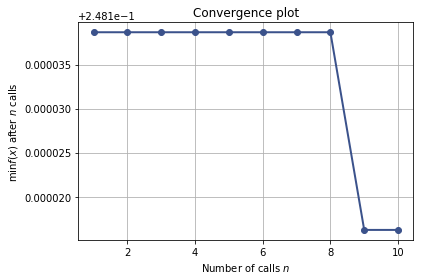

In [29]:
def f(x):
    gc.collect()
    print(x)
    params = {
        'task': 'train',
        'boosting_type': 'dart',
        'learning_rate': x[0],
        'num_leaves': x[1],
        'min_data_in_leaf': x[2],
        'num_iteration': x[3],
        'max_bin': x[4],
        'verbose': 1,
        'objective': 'binary'
    }
    d_train = lgb.Dataset(x_train, label=y_train)
    d_test = lgb.Dataset(x_test, label=y_test)
    gbm = lgb.train(params,
            d_train,
            num_boost_round=100,
            valid_sets=d_test,
            early_stopping_rounds=5)
    
    print('score: ', mean_squared_error(
        gbm.predict(x_test, num_iteration=gbm.best_iteration), y_test))
    gc.collect()
    return mean_squared_error(
        gbm.predict(x_test, num_iteration=gbm.best_iteration), y_test)

# optimize params in these ranges
spaces = [
    (0.01, 0.3), #learning_rate
    (3000, 3500), #num_leaves
    (260, 300), #min_data_in_leaf
    (800, 1000), #num_iteration
    (200, 220) #max_bin
]

# run optimization
res = gp_minimize(
    f, spaces,
    acq_func="EI",
    n_calls=10) # increase n_calls for more performance

# print tuned params
print(res.x)

# plot tuning process
plot_convergence(res)

In [30]:
params = {
    'learning_rate': res.x[0],
    'num_leaves': res.x[1],
    'n_estimators': 200,
    'min_child_samples': 20,
    'colsample_bytree': 0.8,
    'subsample': 1.0,
    'reg_alpha': 0.8,
    'reg_lambda': 0.4,
    'task': 'train',
    'boosting_type': 'dart',
    'min_data_in_leaf': res.x[2],
    'num_iteration': res.x[3],
    'max_bin': res.x[4],
    'verbose': 1,
    'objective': 'binary'
}
params

{'learning_rate': 0.05871558491722697,
 'num_leaves': 3388,
 'n_estimators': 200,
 'min_child_samples': 20,
 'colsample_bytree': 0.8,
 'subsample': 1.0,
 'reg_alpha': 0.8,
 'reg_lambda': 0.4,
 'task': 'train',
 'boosting_type': 'dart',
 'min_data_in_leaf': 277,
 'num_iteration': 815,
 'max_bin': 207,
 'verbose': 1,
 'objective': 'binary'}

**Train LGBM Model**

In [31]:
# params = {
#     'learning_rate': 0.14360424246380565,
#     'num_leaves': 170,
#     'n_estimators': 200,
#     'min_child_samples': 1500,
#     'colsample_bytree': 0.8,
#     'subsample': 1.0,
#     'reg_alpha': 0.8,
#     'reg_lambda': 0.4,
#     'task': 'train',
#     'boosting_type': 'dart',
#     'min_data_in_leaf': 500,
#     'num_iteration': 50,
#     'max_bin': 50000,
#     'verbose': 1,
#     'objective': 'binary'
# }

In [32]:
gc.collect()
d_train = lgb.Dataset(x_train, label=y_train)
d_test = lgb.Dataset(x_test, label=y_test)
clf = lgb.train(params,
        d_train,
        num_boost_round=1000,
        valid_sets=d_test,
        early_stopping_rounds=5)

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning:

Found `num_iteration` in params. Will use it instead of argument



[1]	valid_0's binary_logloss: 0.692357
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.691814
[3]	valid_0's binary_logloss: 0.691366
[4]	valid_0's binary_logloss: 0.691013
[5]	valid_0's binary_logloss: 0.690726
[6]	valid_0's binary_logloss: 0.690454
[7]	valid_0's binary_logloss: 0.690206
[8]	valid_0's binary_logloss: 0.690301
[9]	valid_0's binary_logloss: 0.690087
[10]	valid_0's binary_logloss: 0.689885
[11]	valid_0's binary_logloss: 0.689724
[12]	valid_0's binary_logloss: 0.68976
[13]	valid_0's binary_logloss: 0.689683
[14]	valid_0's binary_logloss: 0.689571
[15]	valid_0's binary_logloss: 0.689478
[16]	valid_0's binary_logloss: 0.689388
[17]	valid_0's binary_logloss: 0.689345
[18]	valid_0's binary_logloss: 0.689308
[19]	valid_0's binary_logloss: 0.689272
[20]	valid_0's binary_logloss: 0.689262
[21]	valid_0's binary_logloss: 0.689257
[22]	valid_0's binary_logloss: 0.689229
[23]	valid_0's binary_logloss: 0.689227
[24]	valid_0's binary_logloss

In [33]:
gc.collect()

55

**Evaluate LGBM Model**

In [34]:
def evaluate_lgbm_model(x_train, x_test, y_train, y_test, params, model):
    gc.collect()
    d_train = lgb.Dataset(x_train, label=y_train)
    d_test = lgb.Dataset(x_test, label=y_test)
    plot_model_performance(y_test, model.predict(x_test))

In [35]:
evaluate_lgbm_model(x_train, x_test, y_train, y_test, params, clf)

R2 score:  0.007161487459306892
Mean Absolute Error: 0.49614207994170717
Mean Squared Error: 0.2480470328143558
Root Mean Squared Error: 0.49804320376284206


**Feature Importance**

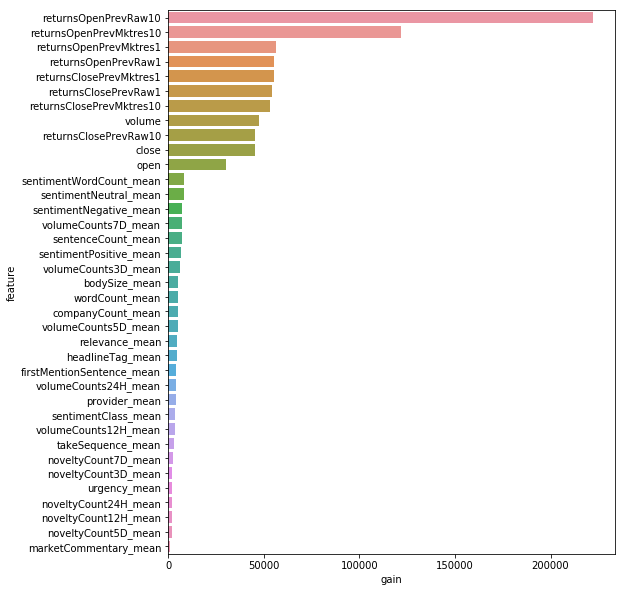

In [36]:
feat_importance = pd.DataFrame()
feat_importance["feature"] = df.columns
feat_importance["gain"] = clf.feature_importance(importance_type='gain')
feat_importance.sort_values(by='gain', ascending=False, inplace=True)
plt.figure(figsize=(8,10))
ax = sns.barplot(y="feature", x="gain", data=feat_importance)

**Write Submission**

In [37]:
days = env.get_prediction_days()

In [ ]:
def write_submission(model, env, days):
    for (market_obs_df, news_obs_df, predictions_template_df) in days:
        news_obs_df = preprocess_news(news_obs_df)
        # Unstack news
        index_df = unstack_asset_codes(news_obs_df)
        news_unstack = merge_news_on_index(news_obs_df, index_df)
        # Group and and get aggregations (mean)
        news_obs_agg = group_news(news_unstack)

        # Join market and news frames
        market_obs_df['date'] = market_obs_df.time.dt.date
        obs_df = market_obs_df.merge(news_obs_agg, how='left', on=['assetCode', 'date'])
        del market_obs_df, news_obs_agg, news_obs_df, news_unstack, index_df
        gc.collect()
        obs_df = obs_df[obs_df.assetCode.isin(predictions_template_df.assetCode)]
        dropped_features =  ['universe', 'date', 
                                             'assetCode', 'assetName', 'time']
        feats = [c for c in obs_df.columns if c not in dropped_features]

        preds = model.predict(obs_df[feats])[:] * 2 - 1
        sub = pd.DataFrame({'assetCode': obs_df['assetCode'], 'confidence': preds})
        predictions_template_df = predictions_template_df.merge(sub, how='left').drop(
            'confidenceValue', axis=1).fillna(0).rename(columns={'confidence':'confidenceValue'})
        
        env.predict(predictions_template_df)
        del obs_df, predictions_template_df, preds, sub
        gc.collect()
    env.write_submission_file()

if 'days' not in globals():
    days = env.get_prediction_days()   
write_submission(clf, env, days)